In [30]:
import time, csv, os, requests, copy

import numpy as np
from numpy.linalg import norm
from numpy.random import randn
from numpy import eye, array, asarray, exp
float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float': '{: 6.4f}'.format})
from math import sqrt

#%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rcParams
rcParams["font.serif"] = "cmr14"
rcParams['savefig.dpi'] = 300
rcParams["figure.dpi"] = 100
rcParams.update({'font.size': 18})
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.0
params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams.update(params)

try: 
    import serial
except:
    !pip3 install pyserial
    import serial

DEG2RAD = np.pi/180.

import struct
from casadi import *
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

opts1 = {"expand":False,'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}
opts0 = {"ipopt.linear_solver":'ma27', "ipopt.tol":1e-2, "expand":False,'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}

In [31]:
def Serial_write(U):
    # special bytes of a space and ! added for eps32 to find start
    buf = struct.pack('%sf' % len(U), *U)
    ser.write(bytearray(b' ')+bytearray(b'!')+buf)

def Request_data():
    # special bytes of a space and & to request data
    ser.write(bytearray(b' ')+bytearray(b'&'))

def Reset_imu():
    # special bytes of a space and + to redo calib
    ser.write(bytearray(b' ')+bytearray(b'+'))

def smootherstep(edge0, edge1, x): 
    # Scale, and clamp x to 0..1 range
    x = np.clip((x - edge0) / (edge1 - edge0), 0.0, 1.0)
    # Evaluate polynomial
    return x * x * x * (x * (x * 6 - 15) + 10)

def Read_data():
    nvar = 5 # 4 floats and checksum
    str_len = 4*nvar
    found_header = False
    tic = time.time()
    data = np.zeros(7)
    for kk in range(str_len+1):     # look for header
        if (ser.read(1) == b'&'):
            if (ser.read(1) == b'!'):
                found_header = True
                break
    if found_header:
        rbytes = ser.read(str_len)
        if (len(rbytes) == str_len):
            try:
                for ii in range(nvar):
                    data[ii] = struct.unpack('f',rbytes[4*ii:4*(ii+1)])[0]
                data[5] = time.time() - tic
                data[6] = np.abs(data[4] - np.sum(data[0:4])) # checksum
                return data
            except:
                data[6] = -1
                return data
        else:
            data[6] = -2
        return data # will be zero if 
    data[6] = -3
    return data

In [2]:
def create_opti(model):
    opti = Opti() # Optimization problem

    # ---- decision variables ---------
    cX = opti.variable(2,model.N+1) # state trajectory
    cU = opti.variable(1,model.N)   # control trajectory (throttle)
    cx0 = cX[0,:]
    cx1 = cX[1,:]
    cUdiff = cU[0,:-1] - cU[0,1:]

    # ---- dynamic constraints - dx/dt = f(x,u)
    f = lambda x,u: model.deriv(x,u)

    dt = model.Tf/model.N # length of a control interval
    for k in range(model.N): # loop over control intervals
        # Runge-Kutta 4 integration
        k1 = f(cX[:,k],         cU[:,k])
        k2 = f(cX[:,k]+dt/2*k1, cU[:,k])
        k3 = f(cX[:,k]+dt/2*k2, cU[:,k])
        k4 = f(cX[:,k]+dt*k3,   cU[:,k])
        x_next = cX[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
        opti.subject_to(cX[:,k+1]==x_next) # close the gaps

    # ---- boundary conditions --------
    p = opti.parameter(1,2)
    opti.subject_to(opti.bounded(-model.Umax,cU,model.Umax)) # control is limited

    opti.subject_to(cx0[0] == p[0])   # start at position 0 ...
    opti.subject_to(cx1[0] == p[1]) # ... from stand-still 
    
    # ---- objective          ---------
    model.opti = opti
    model.params = p, cX, cUdiff, cU
    return model 

def min_casadi(X0,Ref,Uold,Pend):
    if Pend.opti is None:
        tic = time.time()
        Pend = create_opti(Pend)
        p, cX, cUdiff,_ = Pend.params
        Pend.opti.solver('ipopt',opts0) # set numerical backend
        print(f"set up {time.time() - tic:.3f}")
    else:
        p, cX, cUdiff, cU = Pend.params
        Pend.opti.set_initial(Pend.sol.value_variables())
        Pend.opti.solver('ipopt',opts1) # set numerical backend
        Pend.opti.set_initial(cU, Uold)

    Pend.opti.set_value(p[0],X0[0])
    Pend.opti.set_value(p[1],X0[1])

    # ---- objective          ---------
    Refc = MX(Ref.reshape(1,Pend.N+1))
    Z = Refc - cX[0,:]

    # ---- objective          ---------
    Pend.opti.minimize(Rzz[0,0]*dot(Z,Z) + Rzz[1,1]*dot(cX[1,:],cX[1,:]) + Ruu*dot(cUdiff,cUdiff)) 

    # ---- initial values for solver ---
    #tic = time.time()
    Pend.sol = Pend.opti.solve()   # actual solve
    #print(f"compute {time.time() - tic:.3f}")
    return Pend #sol.value(cU), sol.value(cx0)[1], sol.stats()['success']

In [21]:
class Model():
    def __init__ (self):
        self.N = 10 # MPC steps
        self.Fs = 1/0.033 #Hz
        self.Ts = 1/self.Fs
        self.Tf = self.N*self.Ts # MPC plan horizon
        self.opti = None
        self.params = None
        self.sol = None
        self.Umax = 500 # system params
        self.omega_n2 = (5.3761)**2 # measured
        self.damping = 2*0.0485*5.3761 # measured
        self.gain =  40/100/57.3 # measured
        self.A = np.array([[0.0, 1.0],[-self.omega_n2, -self.damping]])
        self.B = np.array([[0.0,self.gain*self.omega_n2]])

    def deriv(self,x,u): #MPC design model
            #return vertcat(x[1], -Pend.omega_n2 *x[0] -Pend.damping*x[1] + Pend.B[:,1][0] * u) 
            #return vertcat(x[1], -Pend.omega_n2 *np.sin(x[0]) -Pend.damping*x[1] + Pend.B[:,1][0] * u) 
            return vertcat(x[1], Pend.A[1,0]*np.sin(x[0]) + Pend.A[1,1]*x[1] + Pend.B[:,1][0] * u) 


#Fd = 0.8546
#wd = 5.3697
#zeta = 0.0485
#wn = 5.3761
       

In [22]:
import scipy.linalg as la
from scipy.linalg import expm, solve_continuous_are, sqrtm, solve_discrete_are

# more on where this conversion comes from later in the course
def DiscretizeQ(A,Bw,vel_std,Bu,dt):
    # find equivalent discrete noise matrix Qd
    Nx,_ = A.shape
    S = np.zeros([2*Nx,2*Nx])
    S[0:Nx,0:Nx] = -A
    S[0:Nx,Nx:2*Nx] = Bw@Bw.T*vel_std**2
    S[Nx:2*Nx,Nx:2*Nx] = A.T
    CC = expm(S*dt)
    Ad = np.transpose(CC[Nx:2*Nx,Nx:2*Nx])
    Qd = Ad@CC[0:Nx,Nx:2*Nx]
    
    Nu = 1
    S = np.zeros([Nx+Nu,Nx+Nu])
    S[0:Nx,0:Nx] = A
    S[0:Nx,Nx:Nx+Nu] = Bu
    CC = expm(S*dt)
    Bd = CC[0:Nx,Nx:Nx+Nu]

    return Qd, Ad, Bd 

Ruu = 30e-3
Rzz = np.array([[1000, 0],[0, 40]])   # performance variable penalty

Pend = Model()
# discrete steady state LQR
Pss = solve_continuous_are(Pend.A, Pend.B.T, Rzz, Ruu)
Kss = Pend.B@Pss/Ruu


In [23]:
# MPC
try:
    ser.close()
except:
    pass

if 1:
    port = '/dev/cu.usbserial-110'
    #port = '/dev/cu.usbserial-10'
    ser = serial.Serial(port,baudrate=115200,timeout=0.001)
    ser.flushInput()
    ser.write(bytearray(b'R'))
    time.sleep(10)

In [53]:
Pend = Model()

y_theta = 0
y_gyro = 0
Tfsim = 15

el_time = []; mtheta = []; gyro = []; 

T_ramp = 0.1 # time for ramp in seconds
edge0 = np.array([2.0])
edge1 = np.array([6.0])
edge2 = np.array([10.0])
edge01 = edge0 + T_ramp         
edge11 = edge1 + T_ramp         
edge21 = edge2 + T_ramp         

# MPC
t_plan = np.linspace(0, Pend.Tf, Pend.N+1) # MPC plan time
print('Ts:           ',Pend.Ts)
print('Plan Horizon: ',Pend.Tf)

# PD
Kp = 200 
Kd = 2/5*Kp 

print([Kss.flatten(),[Kp, Kd]])

Ucomp = np.zeros(Pend.N) # make something up
u_inp = np.zeros(Pend.N)
U_esp = []; U_PD = []; U_sent = []; U_here = []; Tstore =[];

t_start = time.time()
current_time = 0;s_prev_time = 0;c_prev_time = 0;t_print = 0
number_of_failed_reads = 0

def Reference(t):
    return 10.*DEG2RAD*(smootherstep(edge0,edge01,t) - 
                        2*smootherstep(edge1,edge11,t)+smootherstep(edge2,edge21,t))

x = np.array([[0],[0]])
Uold = np.append(Ucomp[1:],Ucomp[-1]) # shift and append guess of 0 to end   
Pend = min_casadi(x,Reference(t_plan),Uold,Pend)
_,_,_,cU  = Pend.params

ser.close()
ser = serial.Serial(port,baudrate=115200,timeout=0.0001)
ser.flushInput()

Serial_write(Ucomp)
Request_data()
time.sleep(0.00001)
data = Read_data()

t_start = time.time()
while(current_time <= Tfsim):
    current_time = time.time() - t_start
    if (current_time >= c_prev_time + Pend.Ts):
        tic = time.time()
        Request_data()
        time.sleep(0.00001)
        data = Read_data()
        if (0 < data[6] < 0.1):
            el_time.append(current_time)
            y_theta = data[0]
            y_gyro = data[1]
            mtheta.append(57.3*y_theta)
            gyro.append(y_gyro)

            U_esp.append(data[2])
            U_sent.append(data[3])
            U_here.append(copy.deepcopy(Ucomp[0]))
            U_PD.append(u_inp[0])
        else:
            number_of_failed_reads += 1
            print(' read fail ',end=' ')

        #MPC
        x = np.array([y_theta, y_gyro*DEG2RAD]) # both in rads now
        Uold = np.append(Ucomp[1:],Ucomp[-1]) # shift and append guess end 
        Pend = min_casadi(x,Reference(current_time + t_plan),Uold,Pend)
        Ucomp = Pend.sol.value(cU)
        # PD
        u_inp = Kp*(Reference(current_time) - y_theta) - Kd*y_gyro* DEG2RAD 
        u_inp = np.clip(u_inp,-Pend.Umax,Pend.Umax)

        # sign change in the system?
        U = [value for value in Ucomp]
        Serial_write(np.round(U[0:3],1))
        Tstore = np.append(Tstore,time.time() - tic)
        c_prev_time = current_time

    if current_time >= t_print + 1:
        print(f'{(current_time)/Tfsim:.2f}',end=' ')
        t_print = current_time
    
Serial_write(np.zeros(Pend.N))
ser.close()
print("\nnumber_of_failed_reads: ",number_of_failed_reads)
print(f"\nCPU Times: min: {np.min(Tstore):,.3f}, median: {np.median(Tstore):.3f}, max: {np.max(Tstore):.3f}")

Ts:            0.033
Plan Horizon:  0.33
[array([ 88.8144,  44.5365]), [200, 80.0]]
set up 0.016
0.07 0.14 0.20 0.27 0.34 0.41 0.48 0.55 0.61 0.68 0.75  read fail  0.82 0.89 0.95 
number_of_failed_reads:  1

CPU Times: min: 0.027, median: 0.028, max: 0.066


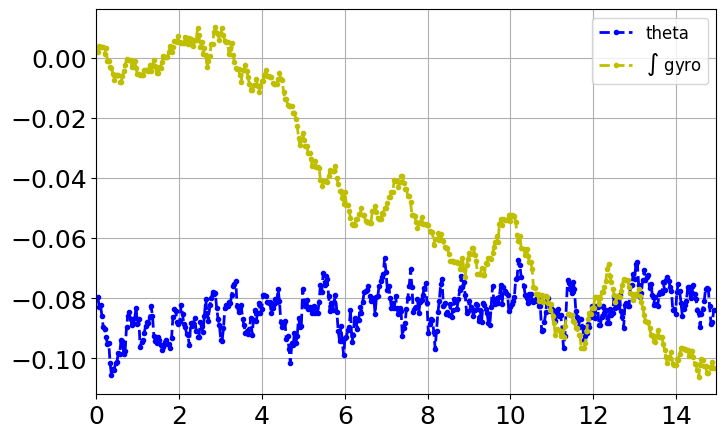

In [54]:
# parts to plot
lg = len(gyro)-2
dt = np.diff(el_time);
ang_GyrY = np.cumsum(gyro[:lg]*dt[:lg])
II = slice(0, lg, 1)
IIm1 = slice(0, lg-1, 1)
IIp1 = slice(1, lg, 1)
l = min(len(el_time),min(len(mtheta),len(gyro)))

fig, ax = plt.subplots()
ax.plot(el_time[II],mtheta[II],'b.--',label='theta')
ax.plot(el_time[II],ang_GyrY[II],'y.--',label=r'$\int$ gyro')
if 0:
    gain = 40/100/57.3
    Inp = [np.sin(omega_n*x/2) for x in el_time[II]]
    ax.plot(el_time[II],Inp,'r-',label=r'Inp')
    
plt.xlim([0, max(el_time)])
plt.legend()
plt.show()

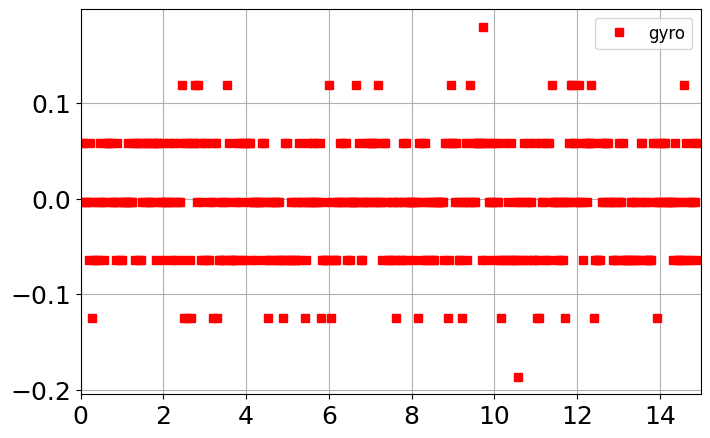

In [55]:
l = min(len(mtheta),len(gyro))
fig, ax = plt.subplots()
#ax.plot(mtheta[II],'b-',label='theta')
ax.step(el_time[II],np.array(gyro[II]),'rs',label='gyro')
plt.xlim([0, max(el_time)])
plt.legend()
plt.show()

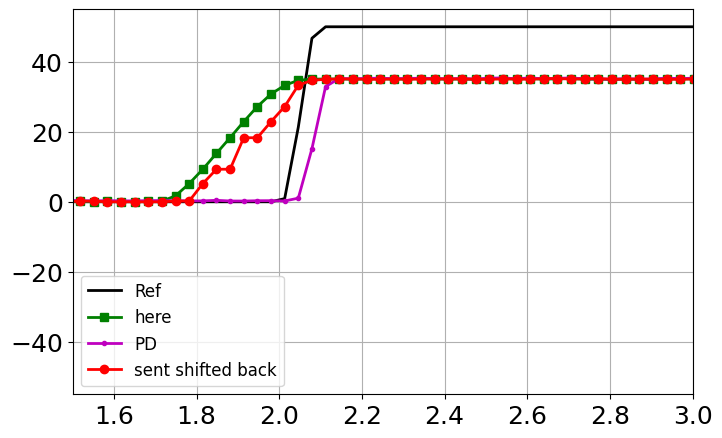

In [67]:
fig, ax = plt.subplots()
ax.plot(el_time[II],5*Reference(el_time[II])/DEG2RAD,'k-',label='Ref')
#ax.plot(el_time[II],mtheta[II],'k:',label='theta')
#ax.plot(el_time[II],gyro[II],'k--',label='gyro')
ax.plot(el_time[II],U_here[II],'gs-',label='here')
ax.plot(el_time[II],U_PD[II],'m.-',label='PD')
#ax.plot(el_time[II],U_esp[II],'b-',label='Esp')
#IIm1 = [x-1 for x in II] # negative sign in system
ax.plot(el_time[IIm1],U_sent[IIp1],'ro-',label='sent shifted back')
plt.legend()
#plt.ylim([-Pend.Umax*1.25, Pend.Umax*1.25])
#plt.ylim([-200, 200])
plt.xlim([1.5, 3])
#plt.xlim([0, Tfsim])
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(2)
ax[0].plot(el_time,el_time,'r.',label='elapsed time')
ax[0].set_xlim([0, max(el_time)])
ax[1].plot(el_time[:-1],np.diff(el_time),'r.',label='diff elapsed time')
ax[1].set_xlim([0, max(el_time)])
ax[1].set_ylim([0, 2*Pend.Ts])
plt.show()

In [ ]:
plt.figure(figsize = (12,5))
plt.plot(el_time[II],Tstore[II],'b',label='$Comp$')
plt.plot(el_time[:-1],np.diff(el_time),'r.',label='diff eltime')
plt.plot([0,el_time[-1]],[Pend.Ts, Pend.Ts],'g--',label='Ts')
plt.xlabel('t')
plt.legend()
plt.ylabel('u(t)')
plt.legend(fontsize=14)
plt.ylim([0,1.5*Pend.Ts])
plt.xlim([0, el_time[-1]])
plt.show()